Model of shoaling behavior based on the Boids model by Craig Reynolds in 1986, using the basic code provided in the Flocker example of the Mesa framework for agent-based modelling in Python. This model is based on 3 parameters that each agent follows:

1. Attraction to (coherence with) other agents,
2. Avoidance of other agents,
3. Alignment with other agents.
The model is based on a bounded, 3D area. Later additions will include obstacles, environmental gradients, and agents with goal-, food-, or safety-seeking behaviour.

This Jupyter notebook version is useful for changing the parameters of the model and seeingthe effect on cohesion without having to re-write the model each time. Parameters explored here include vision and number of individuals and the effect these parameters have on cohesion, measured here as the average distance between an agent and its nearest neighbours.

In [1]:
# Packages and libraries
import numpy as np
import random
from scipy.spatial import KDTree
from mesa import Agent
from mesa import Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import ContinuousSpace
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule

In [2]:
def nnd(model):
    """
    Computes the average nearest neighbor distance for each agent as another
    measure of cohesion.
    """
    fish = np.asarray([agent.pos for agent in model.schedule.agents])
    fish_tree = KDTree(fish)
    means = []
    for me in fish:
        neighbors = fish_tree.query(x=me, k=6)  # includes agent @ dist = 0
        dist = list(neighbors[0])
        dist.pop(0)  # removes closest agent - itself @ dist = 0
        mean_dist = sum(dist) / len(dist)
        means.append(mean_dist)
    return sum(means) / len(means)

In [3]:
# Defines the Agent class for the "fish" in the model
class Fish(Agent):
    """
    A Boid-style agent. Boids have a vision that defines the radius in which
    they look for their neighbors to flock with. Their heading (a unit vector)
    and their interactions with their neighbors - cohering and avoiding -
    define their movement. Separation is their desired minimum distance from
    any other Boid.
    """
    def __init__(self, unique_id, model, pos, speed, velocity, vision,
                 separation, cohere=0.025, separate=0.25, match=0.04):
        """
        Create a new Boid (bird, fish) agent.
        Args:
            unique_id: Unique agent identifier.
            pos: Starting position
            speed: Distance to move per step.
            velocity: numpy vector for the Boid's direction of movement.
            vision: Radius to look around for nearby Boids.
            separation: Minimum distance to maintain from other Boids.
            cohere: the relative importance of matching neighbors' positions
            separate: the relative importance of avoiding close neighbors
            match: the relative importance of matching neighbors' headings
        """
        super().__init__(unique_id, model)
        self.pos = np.array(pos)
        self.speed = speed
        self.velocity = velocity
        self.vision = vision
        self.separation = separation
        self.cohere_factor = cohere
        self.separate_factor = separate
        self.match_factor = match

    def cohere(self, neighbors):
        """
        Return the vector toward the centroid of the local neighbors.
        """
        cohere = np.zeros(2)
        if neighbors:
            for neighbor in neighbors:
                cohere += self.model.space.get_heading(self.pos, neighbor.pos)
            cohere /= len(neighbors)
        return cohere

    def separate(self, neighbors):
        """
        Return a vector away rom any neighbors closer than avoidance distance.
        """
        me = self.pos
        them = (n.pos for n in neighbors)
        separate_vector = np.zeros(2)
        for other in them:
            if self.model.space.get_distance(me, other) < self.separation:
                separate_vector -= self.model.space.get_heading(me, other)
        return separate_vector

    def match_velocity(self, neighbors):
        """
        Have Boids match the velocity of neighbors.
        """
        match_vector = np.zeros(2)
        if neighbors:
            for neighbor in neighbors:
                match_vector += neighbor.velocity
            match_vector /= len(neighbors)
        return match_vector

    def step(self):
        """ 
        Get the Boid's neighbors, compute the new vector, and move accordingly.
        """
        neighbors = self.model.space.get_neighbors(self.pos, self.vision, False)
        self.velocity += (self.cohere(neighbors) * self.cohere_factor +
                          self.separate(neighbors) * self.separate_factor +
                          self.match_velocity(neighbors) * self.match_factor) / 2
        self.velocity /= np.linalg.norm(self.velocity)
        new_pos = self.pos + self.velocity * self.speed
        self.model.space.move_agent(self, new_pos)

In [4]:
# Defines the collective behaviour model
class ShoalModel(Model):
    """ Shoal model class. Handles agent creation, placement and scheduling. """

    def __init__(self,
                 population=100,
                 width=100,
                 height=100,
                 speed=1,
                 vision=10,
                 separation=2,
                 cohere=0.025,
                 separate=0.25,
                 match=0.04):
        """
        Create a new Boids model. Args:
            N: Number of Boids
            width, height: Size of the space.
            speed: how fast the boids should move.
            vision: how far around should each Boid look for its neighbors
            separation: what's the minimum distance each Boid will attempt to
                        keep from any other
            cohere, separate, match: factors for the relative importance of
                                     the three drives.
        """
        self.population = population
        self.vision = vision
        self.speed = speed
        self.separation = separation
        self.schedule = RandomActivation(self)
        self.space = ContinuousSpace(width, height, True,
                                     grid_width=10, grid_height=10)
        self.factors = dict(cohere=cohere, separate=separate, match=match)
        self.make_agents()
        self.running = True

    def make_agents(self):
        """ 
        Create N agents, with random positions and starting velocities. 
        """
        for i in range(self.population):
            x = random.random() * self.space.x_max
            y = random.random() * self.space.y_max
            pos = np.array((x, y))
            velocity = np.random.random(2) * 2 - 1
            fish = Fish(i, self, pos, self.speed, velocity, self.vision,
                        self.separation, **self.factors)
            self.space.place_agent(fish, pos)
            self.schedule.add(fish)

        self.datacollector = DataCollector(
            model_reporters={"Nearest Neighbour Distance": nnd})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [5]:
# Runs the model 1 time for 500 steps.
# These were the presets provided in the Mesa Flocker tutorial.
for j in range(1):
    model = \
        ShoalModel(population=100, width=100, height=100, speed=1, vision=10, separation=2)
    for i in range(500):
        model.step()

In [16]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use('dark_background')

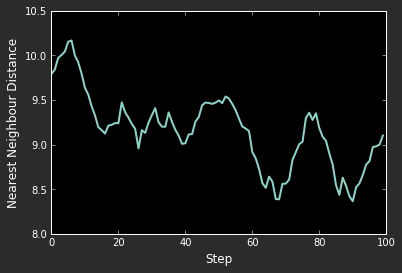

In [14]:
%matplotlib inline

nearestneighbour = model.datacollector.get_model_vars_dataframe()
plt.figure(facecolor='#2B2B2B')
plt.ylabel('Nearest Neighbour Distance', size='large')
plt.xlabel('Step', size='large')
plt.plot(nearestneighbour);

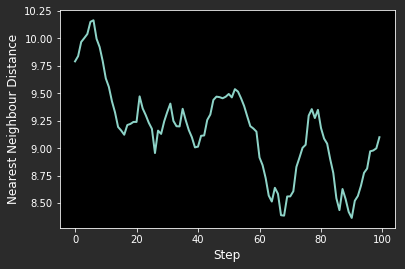

In [10]:
# Can change the inputs to see the effect on the nearest neighbour distance.

for j in range(1):
    model = \
        ShoalModel(population=100, width=100, height=100, speed=1, vision=10, separation=2)
    for i in range(500):
        model.step()
        
# Plot nearest neighbour distance
%matplotlib inline

nearestneighbour = model.datacollector.get_model_vars_dataframe()
plt.figure(facecolor='#2B2B2B')
plt.ylabel('Nearest Neighbour Distance', size='large')
plt.xlabel('Step', size='large')
plt.plot(nearestneighbour);